In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error
import os
import numpy as np
import seaborn as sns
import matplotlib

# This may have needed to be changed #
matplotlib.use('MacOSX')
%matplotlib inline
from matplotlib import pyplot as plt
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [2]:
'''
Please specify the project directory and dataset name. 
The data is expected to be under /data in the project folder.
'''
PATH = '~/Desktop/Projects/cyclexa/'
file_name = 'cyclexa_bixi_predictions.parquet'

In [3]:
def load_data(file_name):
    '''
    Loads the data to a DataFrame. The data is expected to be under /data in the project folder. 
    Returns the DataFrame. 
    '''
    data_path = os.path.join(PATH,'data', file_name)
    data = pd.read_parquet(data_path)
    return data

In [4]:
def get_categorized_by_membership(data, is_member):
    '''
    Filters the data based on the membership information and returns it.
    '''
    if is_member:
        return data[data.is_member == 1]
    else:
        return data[data.is_member == 0]


In [5]:
def get_labels(data):
    '''
    Returns the target columns from the data.
    '''
    y = data.duration_sec
    y_pred = data.predicted_duration_sec
    return y, y_pred

In [6]:
def adjusted_r2(y, y_pred, data):
    '''
    Calculates the Adjusted R2 Score.
    '''
    SS_Residual = sum((y-y_pred)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-data.shape[1]-1)
    return adjusted_r_squared

In [7]:
def evalute_results(data):
    '''
    Evaluates model performance on a series of Regression Metrics. Prints the results on the console.
    '''
    y, y_pred = get_labels(data)  
    print('R2 Score ',r2_score(y, y_pred))    
    print('Adjusted R2 ', adjusted_r2(y, y_pred,data))
    print('RMSE ',mean_squared_error(y, y_pred, squared=False))
    print('Explained Variance score ',explained_variance_score(y, y_pred))    
    print('MAE ',mean_absolute_error(y, y_pred))    

In [8]:
def residuals(y, y_pred):
    '''
    Returns residuals.
    '''
    return y-y_pred

In [9]:
def get_r2_scores_best_and_worst(data):
    '''
    Calculates R2 Score per station. It doesn't include stations with less than two data points.
    Returns the best and worst four stations with their respective R2 scores, as well as the entire R2 Scores array.
    '''
    r2_scores = []
    skipped_stations = []
    for station in get_stations(data):
        station_data = data[data.station_code == station]
        if len(station_data) >= 2:
            r2_scores.append([r2_score(station_data.duration_sec, station_data.predicted_duration_sec), station])
        else:
            skipped_stations.append(station)
    r2_scores.sort(key = lambda x: x[0])
    
    best_4 = r2_scores[-4:]    
    worst_4 = r2_scores[:4]
    return best_4, worst_4, sorted(np.array(r2_scores)[:,0]), skipped_stations

In [10]:
def kl_divergence(p, q):
    '''
    Returns the KL Divergence between two distributions.
    '''
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [11]:
def get_stations(data):
    '''
    Returns the station codes list.
    '''
    return data.station_code.unique().tolist()


In [12]:
def plot_distribution_comparison(data, name):
    '''
    Plots and saves the KL divergence.
    '''
    plot_name = 'Distribution Comparison.png'
    
    plt.figure(figsize=(8,5))
    plt.title('KL(Duration||Predicted Duration) = %1.3f' % kl_divergence(data['duration_sec'],data['predicted_duration_sec']))
    data['duration_sec'].plot.density()
    data['predicted_duration_sec'].plot.density()
    plt.savefig(os.path.join(name,plot_name), dpi = 300)
    plt.show()
    

In [13]:
def plot_boxplot_distribution_durations(data,name):
    '''
    Plots and saves the boxplot of the predicted and real durations.
    '''
    plt.figure(figsize=(8,5))
    title = 'Durations Distribution'
    plot_name = 'Durations Distribution ' + name + '.png'

    plt.title(title)
    data.boxplot(column=['duration_sec', 'predicted_duration_sec'],showmeans=True)
    plt.xticks([1, 2], ['Duration', 'Predicted Duration'])
    plt.savefig(os.path.join(name,plot_name), dpi = 300)
    plt.show()
    

In [14]:
def plot_r2_scores(data, name):
    '''
    Plots and saves the boxplot of R2 distribution.
    '''
    plt.figure(figsize=(8,5))
    title = 'R2 Distribution'
    plot_name = 'R2 Distribution ' + name + '.png'
    plt.title(title)
    
    plt.boxplot(data,showmeans=True)
    plt.savefig(os.path.join(name, plot_name), dpi = 300)    
    plt.show()
    

In [15]:
def plot_residuals(data, scores, name, name_sub):
    '''
    Plots and saves the given four stations' residuals against the predicted results.
    '''

    fig = plt.figure(figsize=(15,15))
    
    title = name_sub+' Residuals vs Predictions'
    plot_name = name_sub +' Residuals vs Predictions.png'
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
  
    ax = fig.add_subplot(2, 2, 1)
    station = scores[0][1]
    station_name = str(int(station))
    station_data = data[data.station_code == station]
    st_y = station_data.duration_sec
    st_y_pred = station_data.predicted_duration_sec
    ax.set_title('Station '+station_name+' R2 Score '+str(round(scores[3][0],2)))
    sns.regplot(x=st_y_pred, y=residuals(st_y, st_y_pred), data=station_data)
    ax.set(xlabel='Predictions', ylabel='Residuals')
    ax = fig.add_subplot(2, 2, 2)
    station = scores[1][1]
    station_name = str(int(station))

    station_data = data[data.station_code == station]
    st_y = station_data.duration_sec
    st_y_pred = station_data.predicted_duration_sec
    ax.set_title('Station '+station_name+' R2 Score '+str(round(scores[2][0],2)))
    sns.regplot(x=st_y_pred, y=residuals(st_y, st_y_pred), data=station_data)
    ax.set(xlabel='Predictions', ylabel='Residuals')
    
    ax = fig.add_subplot(2, 2, 3)
    station = scores[2][1]
    station_name = str(int(station))

    station_data = data[data.station_code == station]
    st_y = station_data.duration_sec
    st_y_pred = station_data.predicted_duration_sec
    ax.set_title('Station '+station_name+' R2 Score '+str(round(scores[1][0],2)))
    sns.regplot(x=st_y_pred, y=residuals(st_y, st_y_pred), data=station_data)
    ax.set(xlabel='Predictions', ylabel='Residuals')
    
    ax = fig.add_subplot(2, 2, 4)
    station = scores[3][1]
    station_name = str(int(station))

    station_data = data[data.station_code == station]
    st_y = station_data.duration_sec
    st_y_pred = station_data.predicted_duration_sec
    ax.set_title('Station '+station_name+' R2 Score '+str(round(scores[0][0],2)))
    sns.regplot(x=st_y_pred, y=residuals(st_y, st_y_pred), data=station_data)
    ax.set(xlabel='Predictions', ylabel='Residuals')
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title)
    plt.savefig(os.path.join(name,plot_name), dpi = 300)
    plt.show()
    

In [16]:
def evaluation_pipeline(data, name):
    '''
    Creates a results folder if doesn't exist. Calls the evaluation and plottin functions. Returns the R2 Scores
    of the set and the skipped stations.
    '''
    if not os.path.exists(name):
        os.mkdir(name)
      
    evalute_results(data)
    
    best_4, worst_4, r2_scores, skipped_stations = get_r2_scores_best_and_worst(data)
    
    plot_residuals(data, best_4, name, 'Best')
    plot_residuals(data, worst_4, name, 'Worst')
    
    plot_r2_scores(r2_scores,name)
    plot_distribution_comparison(data,name)
    plot_boxplot_distribution_durations(data,name)
    
    return r2_scores,skipped_stations

In [17]:
# Loads the data
data = load_data(file_name)

Evaluation on Complete Set

R2 Score  0.3309517138488738
Adjusted R2  0.33094079969923007
RMSE  1026.642308040836
Explained Variance score  0.34194541169366754
MAE  691.2466013367847


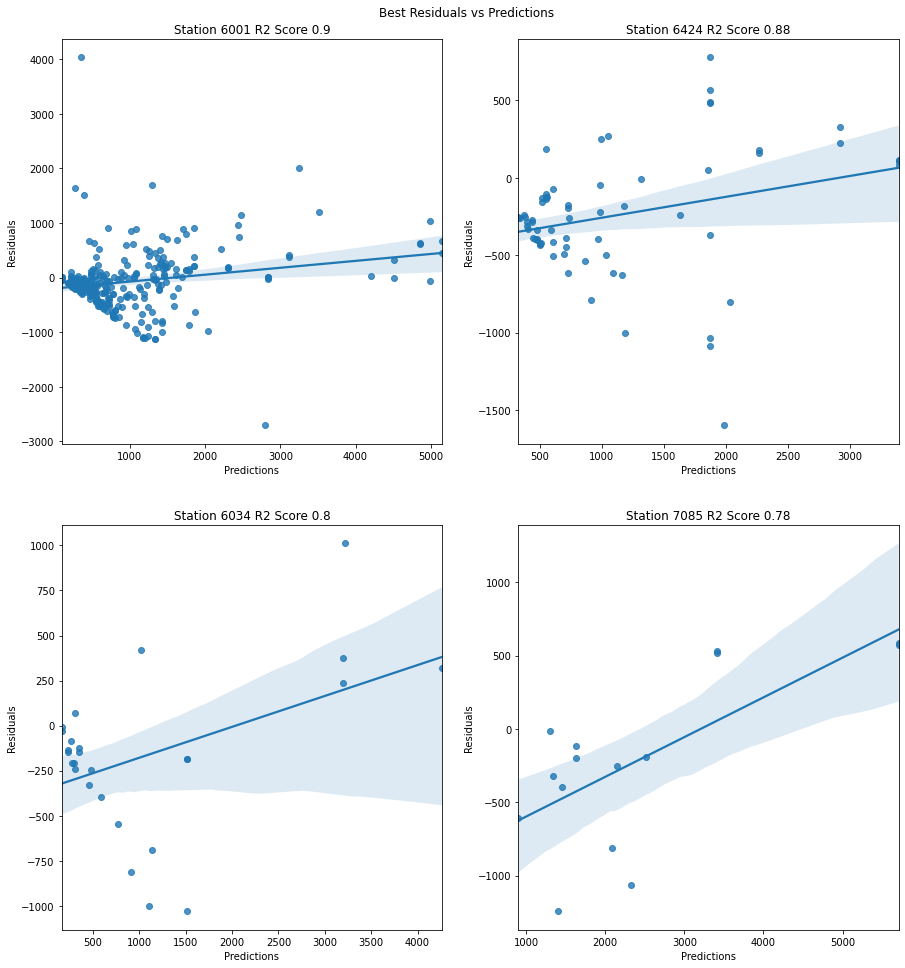

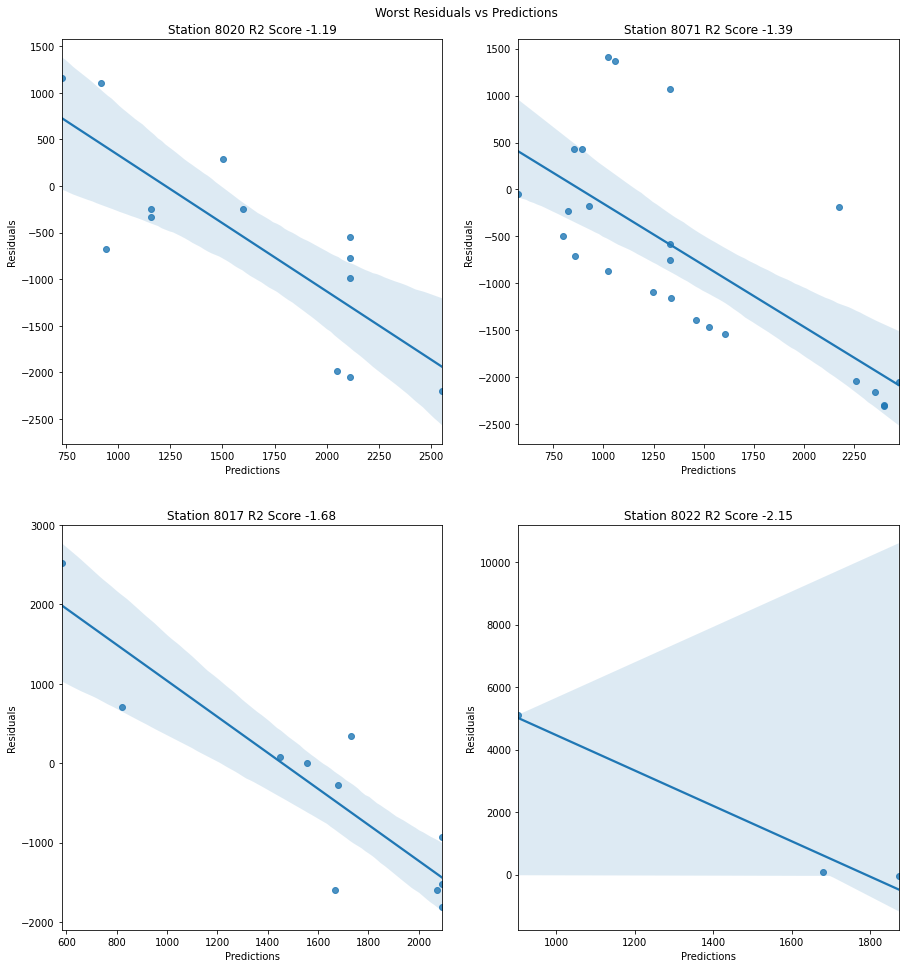

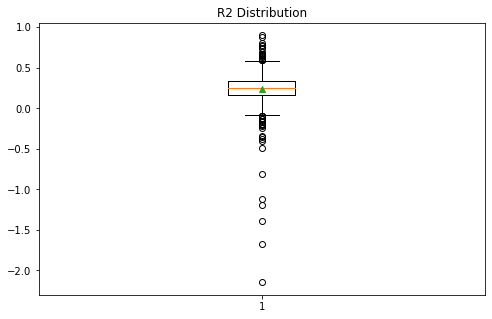

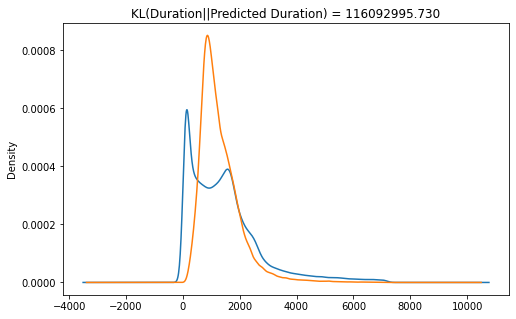

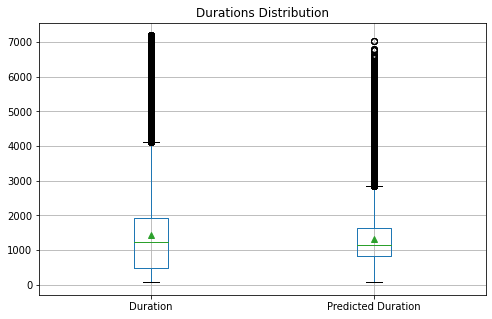

In [18]:
_, skipped_stations = evaluation_pipeline(data, 'Complete Set')

Stations with too few data points are excluded from R2 calculations

In [19]:
print('Stations excluded from the Complete Set:', skipped_stations)

Stations excluded from the Complete Set: []


Evaluation on Member Set

R2 Score  0.2183635674803942
Adjusted R2  0.21834227963582542
RMSE  872.8553174538388
Explained Variance score  0.24502885213241987
MAE  615.2918270827807


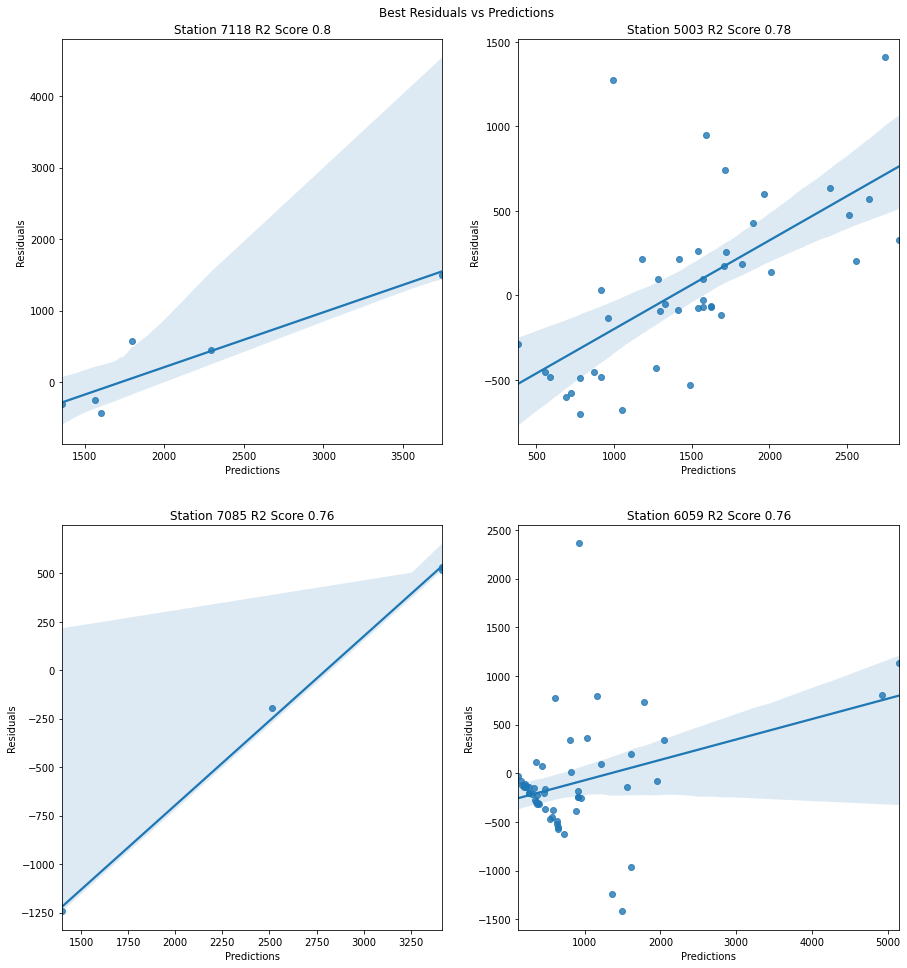

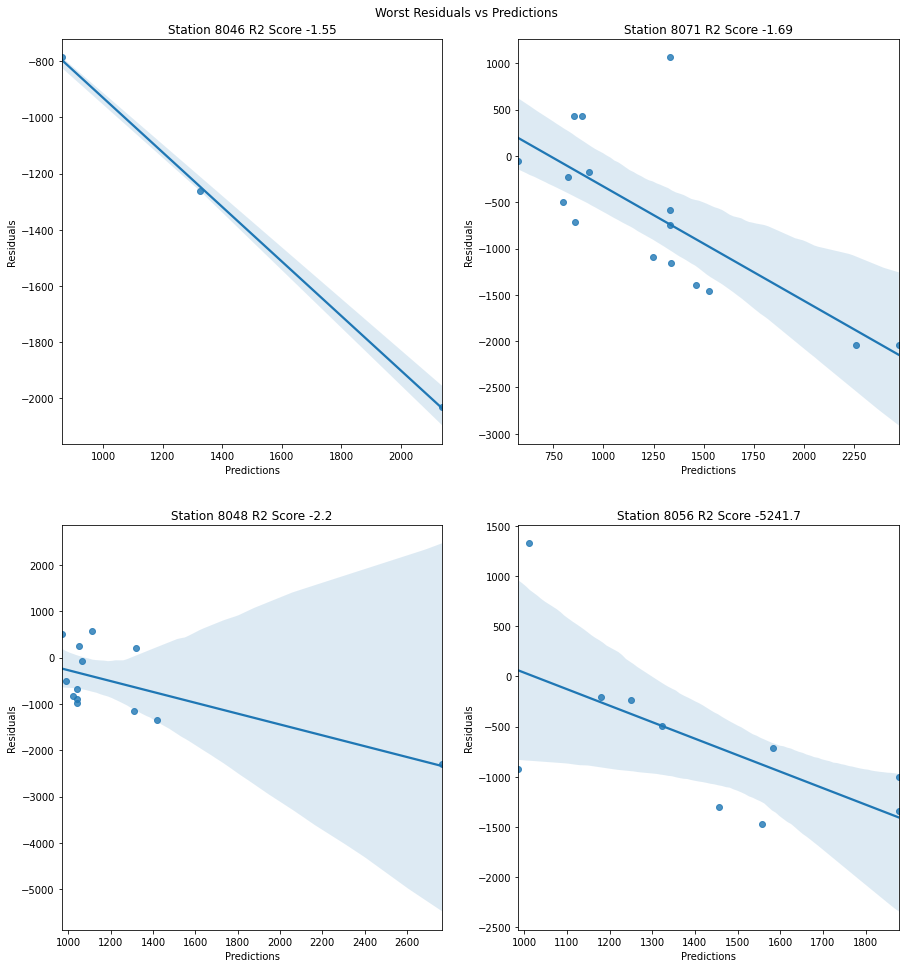

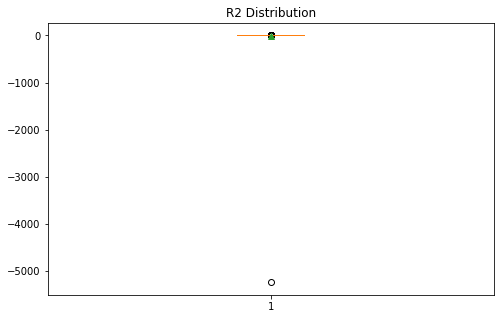

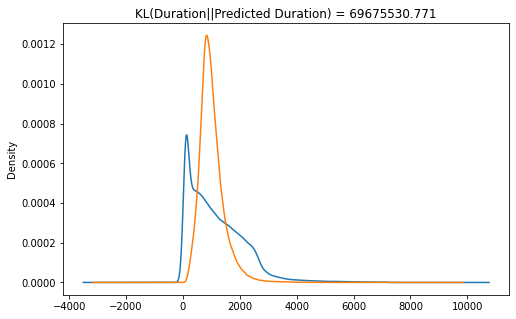

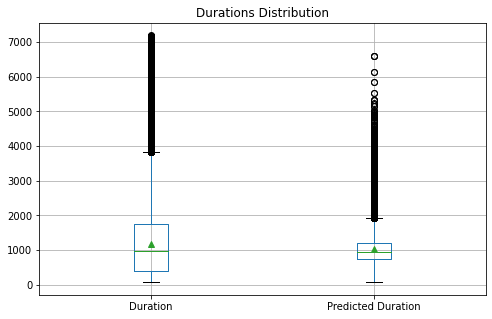

In [20]:
member_data = get_categorized_by_membership(data, is_member = True)
members_r2_scores, members_skipped_stations = evaluation_pipeline(member_data, 'Members Set')

In [21]:
print('Stations excluded from the Members Set:', members_skipped_stations)


Stations excluded from the Members Set: [8022.0]


There is an outlier in the Members Set with R2 score -5241.69. We are removing the outlier.

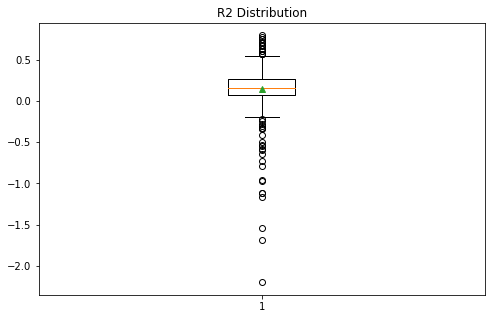

<Figure size 432x288 with 0 Axes>

In [22]:
members_r2_scores = np.delete(members_r2_scores,0)

plot_r2_scores(members_r2_scores, 'Members Set')
plt.savefig(os.path.join('Members Set','R2 Distribution Members Set - Outlier removed'), dpi = 300)
plt.show()

Evalution on non-member data

R2 Score  0.32643348603302347
Adjusted R2  0.3264060855097186
RMSE  1220.7832827332188
Explained Variance score  0.3298832977369798
MAE  804.6952301788622


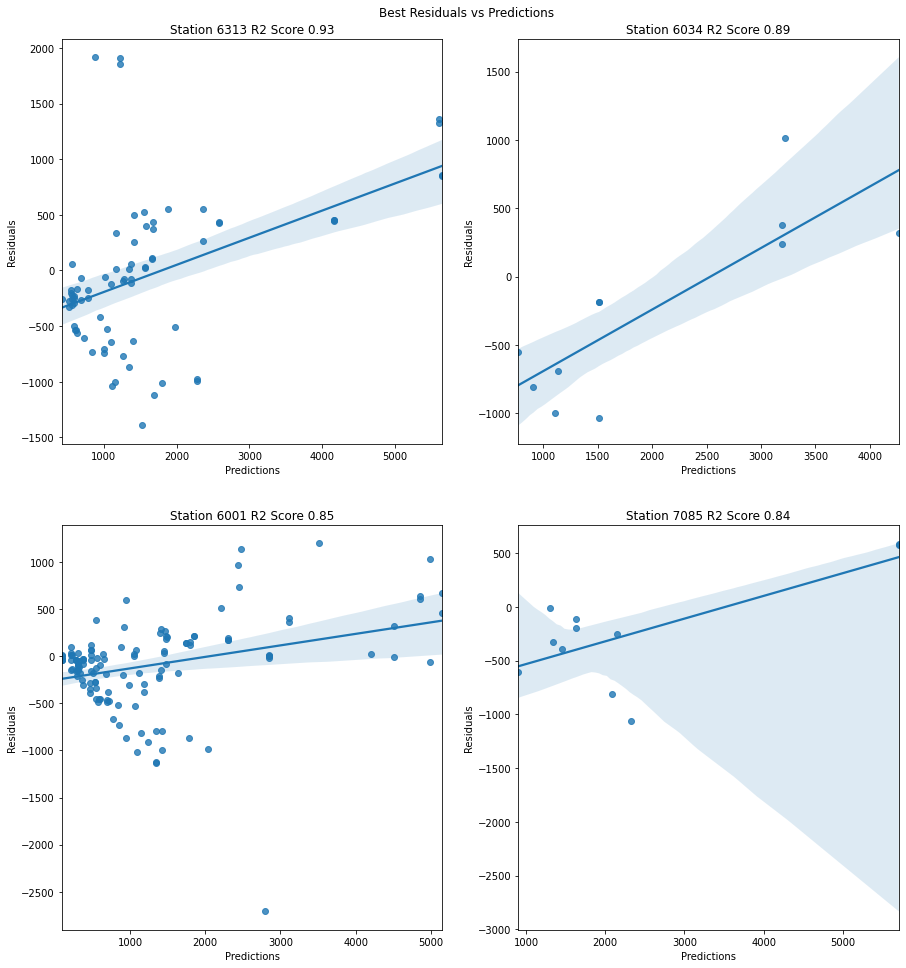

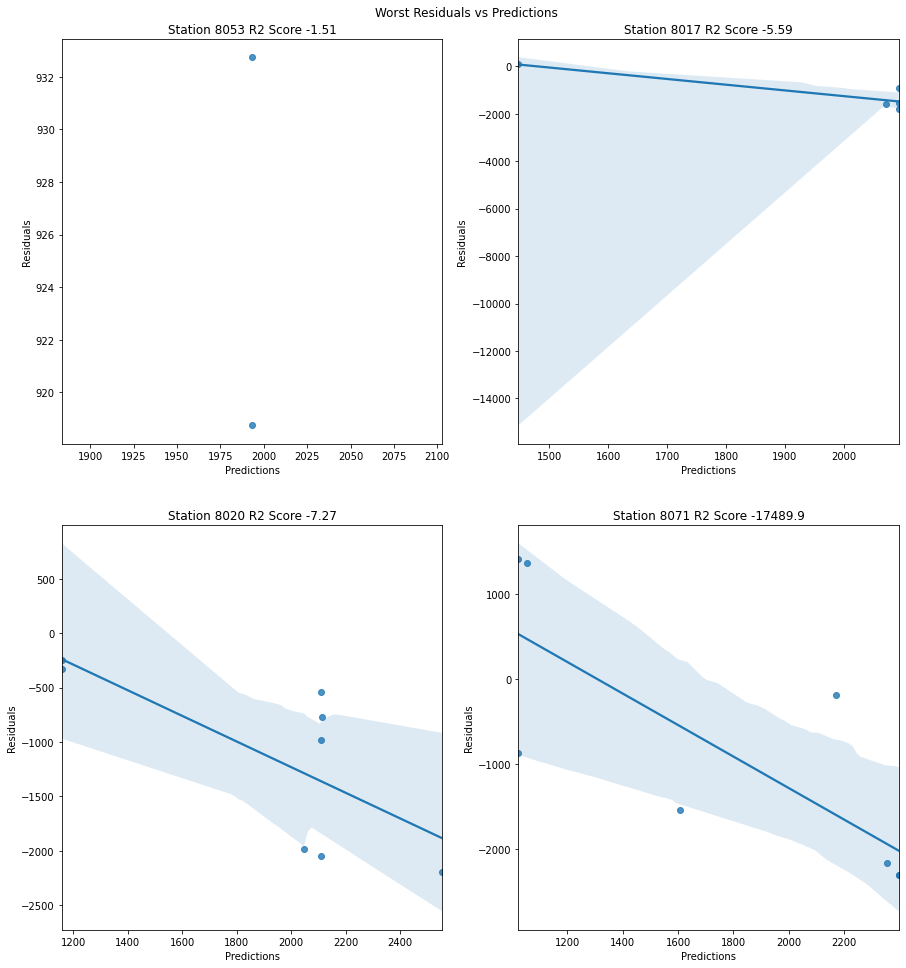

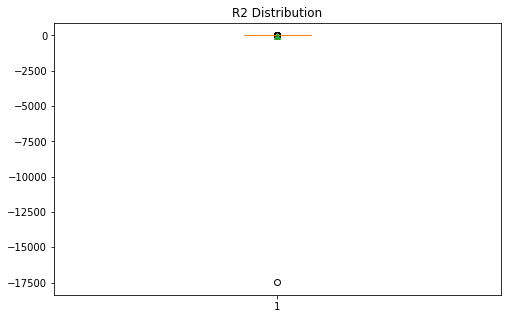

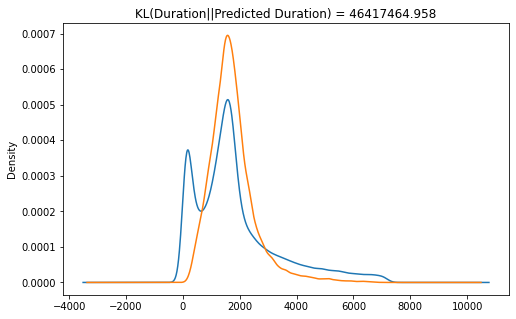

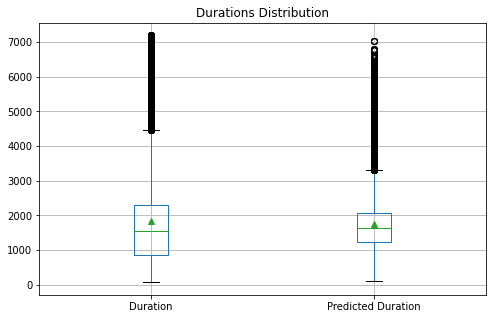

In [23]:
non_member_data = get_categorized_by_membership(data, is_member = False)
non_members_r2_scores, non_members_skipped_stations = evaluation_pipeline(non_member_data, 'Non-Members Set')

There is an outlier in the Members Set with R2 score -17489.9. We are removing the outlier.

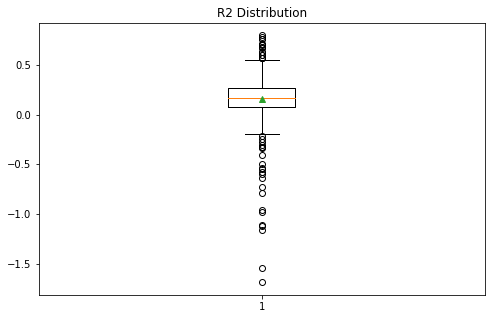

<Figure size 432x288 with 0 Axes>

In [24]:
non_members_r2_scores = np.delete(members_r2_scores,0)

plot_r2_scores(non_members_r2_scores, 'Non-Members Set')
plt.savefig(os.path.join('Non-Members Set','R2 Distribution Non-Members Set - Outlier removed'), dpi = 300)
plt.show()

In [25]:
print('Stations excluded from the Non-Members Set:', non_members_skipped_stations)

Stations excluded from the Non-Members Set: [8013.0]


/Users/mirayyuce/.virtualenvs/thesis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


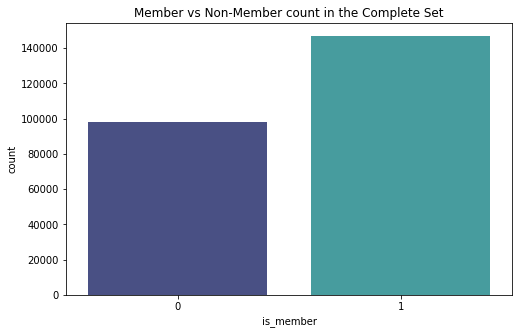

In [26]:
plt.figure(figsize=(8,5))
sns.countplot('is_member',data=data,palette='mako')
plt.title('Member vs Non-Member count in the Complete Set')
plt.savefig(os.path.join('Complete Set','Membership.png'), dpi = 300)
plt.show()